In [ ]:
#Integracion Google Drive
%cd /content/drive/MyDrive/ModelsIATrain/dataset_objects/

/content/drive/MyDrive/ModelsIATrain/dataset_objects


In [ ]:
#clone YOLOv5 
!git clone https://github.com/ultralytics/yolov5  

Cloning into 'yolov5'...
remote: Enumerating objects: 12270, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 12270 (delta 5), reused 9 (delta 1), pack-reused 12250
Receiving objects: 100% (12270/12270), 12.02 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (8491/8491), done.


In [ ]:
#Intalacion de la paqueteria necesaria
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 14.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
#Extraccion de nuestro dataset desde google drive
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EXwPt-9h6Wx7s97Fc2ll3DcqwQePmJGp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EXwPt-9h6Wx7s97Fc2ll3DcqwQePmJGp" -O data.zip && rm -rf /tmp/cookies.txt

--2022-06-23 18:12:23--  https://docs.google.com/uc?export=download&confirm=t&id=1EXwPt-9h6Wx7s97Fc2ll3DcqwQePmJGp
Resolving docs.google.com (docs.google.com)... 74.125.135.101, 74.125.135.138, 74.125.135.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t7h3i9los6qsfuprhvi4r7eqfi7dp257/1656007875000/06942482547493834900/*/1EXwPt-9h6Wx7s97Fc2ll3DcqwQePmJGp?e=download [following]
--2022-06-23 18:12:23--  https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t7h3i9los6qsfuprhvi4r7eqfi7dp257/1656007875000/06942482547493834900/*/1EXwPt-9h6Wx7s97Fc2ll3DcqwQePmJGp?e=download
Resolving doc-10-2k-docs.googleusercontent.com (doc-10-2k-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-10-2k-docs.googleusercontent.com (doc-10-2k-

In [ ]:
#Desempacar dataset
!unzip data.zip
!rm -r data.zip

Archive:  data.zip
   creating: Dataset_Objetos/
   creating: Dataset_Objetos/anotacions/
  inflating: Dataset_Objetos/anotacions/Objeto_1474.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1475.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1200.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1201.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1202.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1203.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1206.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1207.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1208.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1211.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1212.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1214.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1216.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1217.xml  
  inflating: Dataset_Objetos/anotacions/Objeto_1219.xml  
  inflating: Dataset_Objetos/anotacions/

In [ ]:
#Cambio de nombre al usado por defaul por Yolov5
!mv Dataset_Objetos/photos/ Dataset_Objetos/images

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
#Ejemplo de uso
extract_info_from_xml("Dataset_Objetos/anotacions/Objeto_1.xml")

{'bboxes': [{'class': 'egg',
   'xmax': 3286,
   'xmin': 551,
   'ymax': 2698,
   'ymin': 433}],
 'filename': 'Objeto_1.jpg',
 'image_size': (4160, 3120, 3)}

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"pencil": 0,
                           "lemon": 1,
                           "banana": 2,
                           "green_apple": 3,
                           "egg": 4,
                           "tomato": 5,
                           "hand": 6,
                           "pants": 7,
                           "t_shirt": 8,
                           "cucumber": 9}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            
            #Manejo de errores por mal etiquetado
            if b["class"]=="tshirt" or b["class"]=="t-shirt" or b["class"]=="t t-shirt":
              class_id = class_name_to_id_mapping["t_shirt"]
            elif b["class"]=="jeans":
              class_id = class_name_to_id_mapping["pants"]
            elif b["class"]=="apple":
              class_id = class_name_to_id_mapping["green_apple"]
            elif b["class"]=="dog":
              break
            elif b["class"]=="pans":
              class_id = class_name_to_id_mapping["pants"]
            else:
              print(b["class"])
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("labels", info_dict["filename"][:info_dict["filename"].rfind(".")]+".txt")
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
#Crear la carpeta donde se almacenaran los labelling formato yolo
%cd Dataset_Objetos/
!mkdir labels

/content/drive/MyDrive/ModelsIATrain/dataset_objects/Dataset_Objetos


In [ ]:
# Get the annotations
annotations = [os.path.join('anotacions', x) for x in os.listdir('anotacions') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

  1%|          | 16/1645 [00:00<00:10, 155.52it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


  2%|▏         | 32/1645 [00:00<00:37, 42.76it/s] 

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


  4%|▎         | 58/1645 [00:01<00:28, 56.53it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


 33%|███▎      | 551/1645 [00:04<00:07, 153.97it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


 48%|████▊     | 794/1645 [00:05<00:05, 159.41it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't

 54%|█████▍    | 893/1645 [00:06<00:05, 145.26it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


 97%|█████████▋| 1603/1645 [00:10<00:00, 150.75it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])
Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't

 99%|█████████▉| 1634/1645 [00:11<00:00, 147.83it/s]

Invalid Class. Must be one from  dict_keys(['pencil', 'lemon', 'banana', 'green_apple', 'egg', 'tomato', 'hand', 'pants', 't_shirt', 'cucumber'])


100%|██████████| 1645/1645 [00:11<00:00, 146.61it/s]



Objeto_90.png


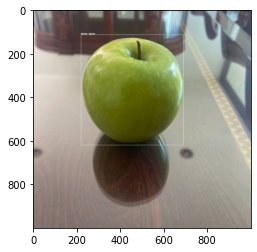

In [ ]:
#Chequeo random de la conversion
random.seed()

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
print()
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
anotacion_fila = annotation_file[annotation_file.find("/")+1:annotation_file.rfind(".")]
for dirpath, dirname, filename in os.walk("images"):
  for name in filename:
    if anotacion_fila == name[:name.rfind(".")]:
      image_file = os.path.join(dirpath, name)
      print(name)
      break

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [ ]:
#Carpetas para guardar las imagenes/etiquetas de entrenamiento, testeo y validacion
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

In [ ]:
#Se obtiene desde el drive el archivo yaml de configuracion
%cd ..
%cd yolov5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YNa5VtTaISiPo9hoTcfAsdINOIbjKt0H' -O data/Dataset_Objetos.yaml

/content/drive/MyDrive/ModelsIATrain/dataset_objects
/content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5
--2022-06-23 18:23:54--  https://docs.google.com/uc?export=download&id=1YNa5VtTaISiPo9hoTcfAsdINOIbjKt0H
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.139, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jn56jmldtq3dol20fj7i0c8jpjj45br/1656008625000/06942482547493834900/*/1YNa5VtTaISiPo9hoTcfAsdINOIbjKt0H?e=download [following]
--2022-06-23 18:23:55--  https://doc-00-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jn56jmldtq3dol20fj7i0c8jpjj45br/1656008625000/06942482547493834900/*/1YNa5VtTaISiPo9hoTcfAsdINOIbjKt0H?e=download
Resolving doc-00-2k-docs.googleusercontent.com (doc-00-2k-docs.googleusercontent.com).

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml  --batch 32 --epochs 100 --data Dataset_Objetos.yaml --weights yolov5s.pt --workers 24 --name Dataset_Objetos

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=Dataset_Objetos.yaml, hyp=hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=Dataset_Objetos, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

In [1]:
#Carpeta para renaudar
%cd /content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5/

/content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5


In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, 

In [ ]:
!python train.py --resume 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
Resuming training from ./runs/train/Dataset_Objetos/weights/last.pt
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, a

In [ ]:
!python detect.py --source ../ImagenesTest/ --weights runs/train/Dataset_Objetos/weights/best.pt --conf 0.25 --name data_object_det

detect: weights=['runs/train/Dataset_Objetos/weights/best.pt'], source=../ImagenesTest/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=data_object_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7037095 parameters, 0 gradients
image 1/7 /content/drive/MyDrive/ModelsIATrain/dataset_objects/ImagenesTest/comida.jpg: 352x640 Done. (0.268s)
image 2/7 /content/drive/MyDrive/ModelsIATrain/dataset_objects/ImagenesTest/gitJul3a_400x400.jpg: 640x640 1 t_shirt, Done. (0.484s)
image 3/7 /content/drive/MyDrive/ModelsIATrain/dataset_objects/ImagenesTest/images.jpeg: 544x640 Done. (0.411s)
image 4/7 /content/dr

In [ ]:
!python detect.py --source ../Dataset_Objetos/images/test/ --weights runs/train/Dataset_Objetos/weights/best.pt --conf 0.5 --name data_object_det

detect: weights=['runs/train/Dataset_Objetos/weights/best.pt'], source=../Dataset_Objetos/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=data_object_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7037095 parameters, 0 gradients
image 1/165 /content/drive/MyDrive/ModelsIATrain/dataset_objects/Dataset_Objetos/images/test/Objeto_1.jpg: 480x640 1 egg, Done. (0.377s)
image 2/165 /content/drive/MyDrive/ModelsIATrain/dataset_objects/Dataset_Objetos/images/test/Objeto_1000.jpg: 640x480 1 cucumber, Done. (0.425s)
image 3/165 /content/drive/MyDrive/ModelsIATrain/dataset_objects/Dataset_Objetos

In [ ]:
!pwd

/content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5


In [ ]:
!python val.py --weights runs/train/Dataset_Objetos/weights/best.pt --data Dataset_Objetos.yaml --task test --name object_det

val: data=/content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5/data/Dataset_Objetos.yaml, weights=['runs/train/Dataset_Objetos/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=object_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7037095 parameters, 0 gradients
test: Scanning '/content/drive/MyDrive/ModelsIATrain/dataset_objects/yolov5/../Dataset_Objetos/labels/test' images and labels...51 found, 0 missing, 0 empty, 0 corrupt:  31% 51/165 [00:26<00:52,  2.15it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlu

In [3]:
!du -h --max-depth=1 | sort -h -r

4.1G	.
3.4G	./Dataset_Objetos
754M	./yolov5
4.0K	./ImagenesTest
